In [243]:
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from scipy.io import loadmat
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import random

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [289]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=1000):
    loss_history = []
    f1_history = []
    best_val_f1 = float('-inf')
    counter = 0

    squeduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.75)

    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        model.eval()
        acc, f1, pred = eval_node_classifier(model, graph, graph.val_mask)
        loss_history.append(loss.item())
        f1_history.append(f1)


        counter += 1
        squeduler.step()

        if f1 > best_val_f1:
            best_val_f1 = f1
            torch.save(model.state_dict(), 'best_model.pth')
            counter = 0

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

        if counter > 300:
            break

    model.load_state_dict(torch.load('best_model.pth'))
    return model, loss_history, f1_history


def eval_node_classifier(model, graph, mask):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    # Macro f1 score
    predictions = pred[mask].cpu().numpy()
    y_true = graph.y[mask].cpu().numpy()
    f1 = f1_score(y_true, predictions, average='macro')

    return acc, f1, pred

In [290]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [291]:
# Loading data
data_file = loadmat('./Data/Amazon.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

with open('./Data/amz_homo_adjlists.pickle', 'rb') as file:
    homo = pickle.load(file)

In [349]:
train_mask = torch.zeros(11944, dtype=torch.bool)
val_mask = torch.zeros(11944, dtype=torch.bool)
test_mask = torch.zeros(11944, dtype=torch.bool)

nodes = list(range(3305, 11944))
random.seed(0)
random.shuffle(nodes)
train_nodes = nodes[:int(0.6*len(nodes))]
val_nodes = nodes[int(0.6*len(nodes)):int(0.8*len(nodes))]
test_nodes = nodes[int(0.8*len(nodes)):]

train_mask[train_nodes] = True
val_mask[val_nodes] = True
test_mask[test_nodes] = True

Data class atributes:
 - data.x: Node feature matrix with shape [num_nodes, num_node_features]

 - data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

 - data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

 - data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

 - data.pos: Node position matrix with shape [num_nodes, num_dimensions]

In [293]:
edges_list = []
for i in range(len(homo)):
    edges_list.extend([(i, node) for node in homo[i]])

edges_list = np.array(edges_list)
edges_list = edges_list.transpose()

In [294]:
graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index=torch.tensor(edges_list), 
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask)

In [295]:
graph

Data(x=[11944, 25], edge_index=[2, 8808728], y=[11944], train_mask=[11944], val_mask=[11944], test_mask=[11944])

In [296]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Simple GCN model (https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275)
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(25, 16)
        self.conv2 = GCNConv(16, 8)
        self.conv3 = GCNConv(8, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        return x

In [297]:
simple_model = GCN()
simple_model = simple_model.to(device)
graph = graph.to(device)

In [298]:
simple_model(graph).shape

torch.Size([11944, 2])

In [299]:
optimizer_gcn = torch.optim.Adam(simple_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
simple_model, loss_hist, f1_hist = train_node_classifier(simple_model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(simple_model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 12/1000 [00:00<01:02, 15.71it/s]

Epoch: 010, Train Loss: 2.505, Val Acc: 0.884


  2%|▏         | 22/1000 [00:01<01:02, 15.60it/s]

Epoch: 020, Train Loss: 3.039, Val Acc: 0.881


  3%|▎         | 32/1000 [00:02<01:01, 15.65it/s]

Epoch: 030, Train Loss: 4.961, Val Acc: 0.889


  4%|▍         | 42/1000 [00:02<01:00, 15.74it/s]

Epoch: 040, Train Loss: 0.712, Val Acc: 0.883


  5%|▌         | 52/1000 [00:03<00:59, 15.92it/s]

Epoch: 050, Train Loss: 0.695, Val Acc: 0.888


  6%|▌         | 62/1000 [00:03<00:59, 15.80it/s]

Epoch: 060, Train Loss: 0.767, Val Acc: 0.798


  7%|▋         | 72/1000 [00:04<00:58, 15.90it/s]

Epoch: 070, Train Loss: 0.691, Val Acc: 0.866


  8%|▊         | 82/1000 [00:05<00:58, 15.69it/s]

Epoch: 080, Train Loss: 0.630, Val Acc: 0.850


  9%|▉         | 92/1000 [00:05<00:56, 16.17it/s]

Epoch: 090, Train Loss: 0.613, Val Acc: 0.815


 10%|█         | 102/1000 [00:06<00:56, 15.77it/s]

Epoch: 100, Train Loss: 0.595, Val Acc: 0.803


 11%|█         | 112/1000 [00:07<00:57, 15.56it/s]

Epoch: 110, Train Loss: 0.577, Val Acc: 0.795


 12%|█▏        | 122/1000 [00:07<00:55, 15.80it/s]

Epoch: 120, Train Loss: 0.564, Val Acc: 0.786


 13%|█▎        | 132/1000 [00:08<00:54, 15.80it/s]

Epoch: 130, Train Loss: 0.554, Val Acc: 0.770


 14%|█▍        | 142/1000 [00:08<00:52, 16.25it/s]

Epoch: 140, Train Loss: 0.547, Val Acc: 0.748


 15%|█▌        | 152/1000 [00:09<00:53, 15.96it/s]

Epoch: 150, Train Loss: 0.540, Val Acc: 0.748


 16%|█▌        | 162/1000 [00:10<00:52, 15.89it/s]

Epoch: 160, Train Loss: 0.534, Val Acc: 0.736


 17%|█▋        | 172/1000 [00:10<00:52, 15.73it/s]

Epoch: 170, Train Loss: 0.528, Val Acc: 0.735


 18%|█▊        | 182/1000 [00:11<00:51, 15.76it/s]

Epoch: 180, Train Loss: 0.523, Val Acc: 0.734


 19%|█▉        | 192/1000 [00:12<00:49, 16.28it/s]

Epoch: 190, Train Loss: 0.518, Val Acc: 0.719


 20%|██        | 202/1000 [00:12<00:50, 15.74it/s]

Epoch: 200, Train Loss: 0.514, Val Acc: 0.714


 21%|██        | 212/1000 [00:13<00:49, 16.03it/s]

Epoch: 210, Train Loss: 0.511, Val Acc: 0.715


 22%|██▏       | 222/1000 [00:14<00:49, 15.86it/s]

Epoch: 220, Train Loss: 0.510, Val Acc: 0.725


 23%|██▎       | 232/1000 [00:14<00:48, 15.85it/s]

Epoch: 230, Train Loss: 0.509, Val Acc: 0.717


 24%|██▍       | 242/1000 [00:15<00:48, 15.71it/s]

Epoch: 240, Train Loss: 0.509, Val Acc: 0.717


 25%|██▌       | 252/1000 [00:15<00:47, 15.75it/s]

Epoch: 250, Train Loss: 0.508, Val Acc: 0.714


 26%|██▌       | 262/1000 [00:16<00:47, 15.62it/s]

Epoch: 260, Train Loss: 0.508, Val Acc: 0.709


 27%|██▋       | 272/1000 [00:17<00:46, 15.77it/s]

Epoch: 270, Train Loss: 0.508, Val Acc: 0.708


 28%|██▊       | 282/1000 [00:17<00:45, 15.82it/s]

Epoch: 280, Train Loss: 0.508, Val Acc: 0.708


 29%|██▉       | 292/1000 [00:18<00:44, 15.84it/s]

Epoch: 290, Train Loss: 0.507, Val Acc: 0.707


 30%|███       | 302/1000 [00:19<00:44, 15.75it/s]

Epoch: 300, Train Loss: 0.507, Val Acc: 0.707


 31%|███       | 312/1000 [00:19<00:43, 15.90it/s]

Epoch: 310, Train Loss: 0.507, Val Acc: 0.707


 32%|███▏      | 322/1000 [00:20<00:43, 15.73it/s]

Epoch: 320, Train Loss: 0.506, Val Acc: 0.707


 33%|███▎      | 332/1000 [00:20<00:42, 15.88it/s]

Epoch: 330, Train Loss: 0.507, Val Acc: 0.711


 34%|███▍      | 342/1000 [00:21<00:40, 16.05it/s]

Epoch: 340, Train Loss: 0.506, Val Acc: 0.697


 35%|███▌      | 352/1000 [00:22<00:40, 15.89it/s]

Epoch: 350, Train Loss: 0.506, Val Acc: 0.708


 36%|███▌      | 362/1000 [00:22<00:39, 15.98it/s]

Epoch: 360, Train Loss: 0.505, Val Acc: 0.707


 36%|███▋      | 363/1000 [00:22<00:40, 15.80it/s]

Test Acc: 0.852, Test F1: 0.630


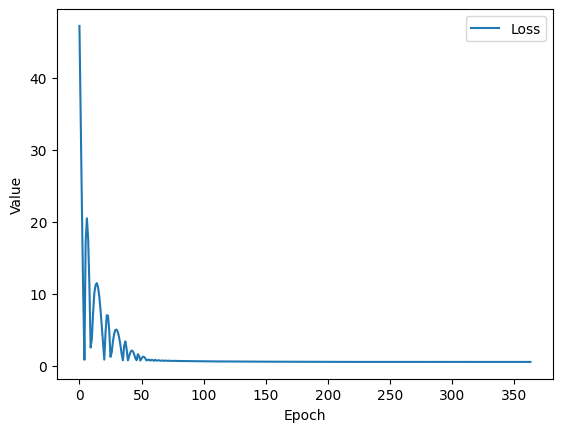

In [300]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


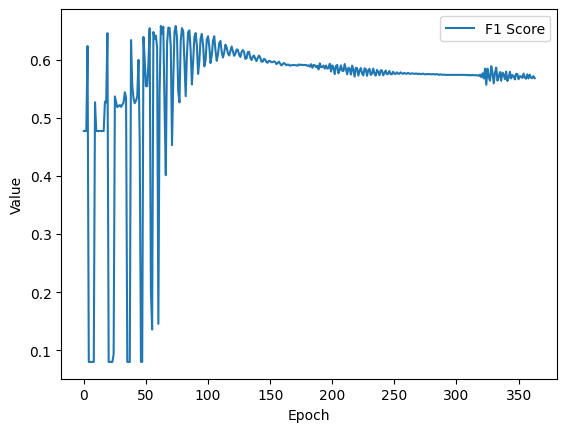

In [301]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

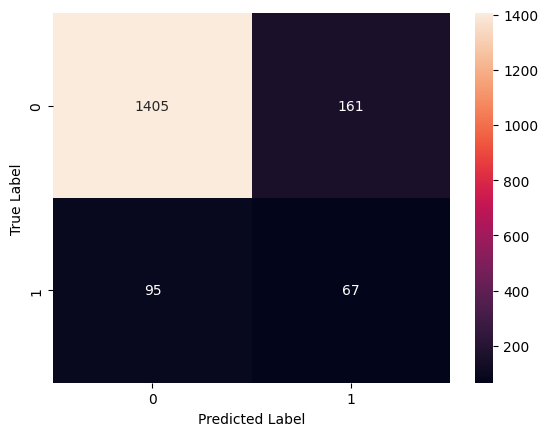

In [302]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### 2nd test - Amazon data

In [303]:
# Loading data
data_file = loadmat('./Data/Amazon.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

In [304]:
with open('./Data/amz_upu_adjlists.pickle', 'rb') as file:
    upu = pickle.load(file)

with open('./Data/amz_usu_adjlists.pickle', 'rb') as file:
    usu = pickle.load(file)

with open('./Data/amz_uvu_adjlists.pickle', 'rb') as file:
    uvu = pickle.load(file)

In [305]:
edges_list_p = []
for i in range(len(upu)):
    edges_list_p.extend([(i, node) for node in upu[i]])

edges_list_p = np.array(edges_list_p)
edges_list_p = edges_list_p.transpose()

In [306]:
edges_list_s = []
for i in range(len(upu)):
    edges_list_s.extend([(i, node) for node in usu[i]])

edges_list_s = np.array(edges_list_s)
edges_list_s = edges_list_s.transpose()

In [307]:
edges_list_v = []
for i in range(len(upu)):
    edges_list_v.extend([(i, node) for node in uvu[i]])

edges_list_v = np.array(edges_list_v)
edges_list_v = edges_list_v.transpose()

In [308]:
graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index_v=torch.tensor(edges_list_v), 
            edge_index_p=torch.tensor(edges_list_p),
            edge_index_s=torch.tensor(edges_list_s),
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask)

In [309]:
graph

Data(x=[11944, 25], y=[11944], edge_index_v=[2, 2085418], edge_index_p=[2, 363160], edge_index_s=[2, 7144902], train_mask=[11944], val_mask=[11944], test_mask=[11944])

In [310]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_p = GCNConv(25, 20)
        self.conv2_p = GCNConv(20, 15)
        self.conv3_p = GCNConv(15, 10)

        self.conv1_s = GCNConv(25, 20)
        self.conv2_s = GCNConv(20, 15)
        self.conv3_s = GCNConv(15, 10)

        self.conv1_v = GCNConv(25, 20)
        self.conv2_v = GCNConv(20, 15)
        self.conv3_v = GCNConv(15, 10)


        self.dropout = nn.Dropout(0.05)

        self.projection = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )





    def forward(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.conv1_p(x, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv2_p(x_p, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv3_p(x_p, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.conv1_s(x, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv2_s(x_s, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv3_s(x_s, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.conv1_v(x, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv2_v(x_v, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv3_v(x_v, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.dropout(x)
        x = self.projection(x)
        return x

In [311]:
model = GCN()
model = model.to(device)

graph = graph.to(device)

In [312]:
optimizer_gcn = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
model, loss_hist, f1_hist = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 11/1000 [00:01<01:41,  9.79it/s]

Epoch: 010, Train Loss: 0.884, Val Acc: 0.922


  2%|▏         | 22/1000 [00:02<01:37, 10.06it/s]

Epoch: 020, Train Loss: 0.550, Val Acc: 0.850


  3%|▎         | 32/1000 [00:03<01:36, 10.07it/s]

Epoch: 030, Train Loss: 0.496, Val Acc: 0.825


  4%|▍         | 40/1000 [00:04<01:35, 10.02it/s]

Epoch: 040, Train Loss: 0.465, Val Acc: 0.831


  5%|▌         | 50/1000 [00:05<01:35,  9.96it/s]

Epoch: 050, Train Loss: 0.440, Val Acc: 0.833


  6%|▌         | 61/1000 [00:06<01:33,  9.99it/s]

Epoch: 060, Train Loss: 0.481, Val Acc: 0.829


  7%|▋         | 72/1000 [00:07<01:32, 10.04it/s]

Epoch: 070, Train Loss: 0.449, Val Acc: 0.810


  8%|▊         | 82/1000 [00:08<01:31, 10.00it/s]

Epoch: 080, Train Loss: 0.421, Val Acc: 0.789


  9%|▉         | 92/1000 [00:09<01:30,  9.99it/s]

Epoch: 090, Train Loss: 0.405, Val Acc: 0.855


 10%|█         | 101/1000 [00:10<01:30,  9.99it/s]

Epoch: 100, Train Loss: 0.386, Val Acc: 0.828


 11%|█         | 111/1000 [00:11<01:28, 10.06it/s]

Epoch: 110, Train Loss: 0.375, Val Acc: 0.833


 12%|█▏        | 122/1000 [00:12<01:28,  9.97it/s]

Epoch: 120, Train Loss: 0.365, Val Acc: 0.927


 13%|█▎        | 132/1000 [00:13<01:26, 10.01it/s]

Epoch: 130, Train Loss: 0.352, Val Acc: 0.843


 14%|█▍        | 141/1000 [00:14<01:24, 10.12it/s]

Epoch: 140, Train Loss: 0.364, Val Acc: 0.899


 15%|█▌        | 151/1000 [00:15<01:24, 10.02it/s]

Epoch: 150, Train Loss: 0.339, Val Acc: 0.855


 16%|█▌        | 162/1000 [00:16<01:23, 10.01it/s]

Epoch: 160, Train Loss: 0.426, Val Acc: 0.928


 17%|█▋        | 172/1000 [00:17<01:22, 10.01it/s]

Epoch: 170, Train Loss: 0.365, Val Acc: 0.834


 18%|█▊        | 182/1000 [00:18<01:21, 10.06it/s]

Epoch: 180, Train Loss: 0.353, Val Acc: 0.848


 19%|█▉        | 190/1000 [00:19<01:20, 10.05it/s]

Epoch: 190, Train Loss: 0.331, Val Acc: 0.888


 20%|██        | 201/1000 [00:20<01:18, 10.23it/s]

Epoch: 200, Train Loss: 0.347, Val Acc: 0.781


 21%|██        | 211/1000 [00:21<01:18, 10.05it/s]

Epoch: 210, Train Loss: 0.323, Val Acc: 0.910


 22%|██▏       | 221/1000 [00:22<01:17,  9.99it/s]

Epoch: 220, Train Loss: 0.332, Val Acc: 0.944


 23%|██▎       | 231/1000 [00:23<01:16, 10.04it/s]

Epoch: 230, Train Loss: 0.377, Val Acc: 0.934


 24%|██▍       | 241/1000 [00:24<01:13, 10.27it/s]

Epoch: 240, Train Loss: 0.328, Val Acc: 0.908


 25%|██▌       | 252/1000 [00:25<01:14, 10.10it/s]

Epoch: 250, Train Loss: 0.316, Val Acc: 0.932


 26%|██▌       | 262/1000 [00:26<01:12, 10.16it/s]

Epoch: 260, Train Loss: 0.312, Val Acc: 0.843


 27%|██▋       | 270/1000 [00:27<01:12, 10.07it/s]

Epoch: 270, Train Loss: 0.292, Val Acc: 0.907


 28%|██▊       | 280/1000 [00:28<01:12, 10.00it/s]

Epoch: 280, Train Loss: 0.301, Val Acc: 0.830


 29%|██▉       | 291/1000 [00:29<01:10, 10.01it/s]

Epoch: 290, Train Loss: 0.304, Val Acc: 0.921


 30%|███       | 301/1000 [00:30<01:09, 10.12it/s]

Epoch: 300, Train Loss: 0.482, Val Acc: 0.951


 31%|███       | 311/1000 [00:31<01:08, 10.07it/s]

Epoch: 310, Train Loss: 0.435, Val Acc: 0.828


 32%|███▏      | 321/1000 [00:32<01:06, 10.20it/s]

Epoch: 320, Train Loss: 0.391, Val Acc: 0.809


 33%|███▎      | 331/1000 [00:33<01:06,  9.99it/s]

Epoch: 330, Train Loss: 0.356, Val Acc: 0.892


 34%|███▍      | 341/1000 [00:34<01:06,  9.98it/s]

Epoch: 340, Train Loss: 0.330, Val Acc: 0.846


 35%|███▌      | 351/1000 [00:35<01:04, 10.02it/s]

Epoch: 350, Train Loss: 0.306, Val Acc: 0.840


 36%|███▌      | 362/1000 [00:36<01:04,  9.91it/s]

Epoch: 360, Train Loss: 0.304, Val Acc: 0.884


 37%|███▋      | 371/1000 [00:37<01:03,  9.97it/s]

Epoch: 370, Train Loss: 0.293, Val Acc: 0.921


 38%|███▊      | 381/1000 [00:38<01:01, 10.04it/s]

Epoch: 380, Train Loss: 0.283, Val Acc: 0.881


 39%|███▉      | 392/1000 [00:39<01:00,  9.99it/s]

Epoch: 390, Train Loss: 0.275, Val Acc: 0.906


 40%|████      | 401/1000 [00:40<01:00,  9.93it/s]

Epoch: 400, Train Loss: 0.274, Val Acc: 0.892


 41%|████      | 411/1000 [00:41<00:58, 10.02it/s]

Epoch: 410, Train Loss: 0.267, Val Acc: 0.873


 42%|████▏     | 421/1000 [00:42<00:58,  9.98it/s]

Epoch: 420, Train Loss: 0.267, Val Acc: 0.866


 43%|████▎     | 431/1000 [00:43<00:56, 10.04it/s]

Epoch: 430, Train Loss: 0.272, Val Acc: 0.927


 44%|████▍     | 441/1000 [00:44<00:56,  9.97it/s]

Epoch: 440, Train Loss: 0.271, Val Acc: 0.903


 45%|████▌     | 452/1000 [00:45<00:54, 10.03it/s]

Epoch: 450, Train Loss: 0.380, Val Acc: 0.731


 46%|████▌     | 461/1000 [00:46<00:54,  9.93it/s]

Epoch: 460, Train Loss: 0.346, Val Acc: 0.905


 47%|████▋     | 472/1000 [00:47<00:52,  9.99it/s]

Epoch: 470, Train Loss: 0.315, Val Acc: 0.918


 48%|████▊     | 482/1000 [00:48<00:51, 10.03it/s]

Epoch: 480, Train Loss: 0.307, Val Acc: 0.891


 49%|████▉     | 492/1000 [00:49<00:50, 10.10it/s]

Epoch: 490, Train Loss: 0.286, Val Acc: 0.885


 50%|█████     | 502/1000 [00:50<00:49, 10.11it/s]

Epoch: 500, Train Loss: 0.284, Val Acc: 0.899


 51%|█████     | 511/1000 [00:51<00:49,  9.90it/s]

Epoch: 510, Train Loss: 0.273, Val Acc: 0.909


 52%|█████▏    | 521/1000 [00:52<00:48,  9.95it/s]

Epoch: 520, Train Loss: 0.262, Val Acc: 0.897


 53%|█████▎    | 531/1000 [00:53<00:46, 10.01it/s]

Epoch: 530, Train Loss: 0.280, Val Acc: 0.872


 54%|█████▍    | 541/1000 [00:54<00:46,  9.94it/s]

Epoch: 540, Train Loss: 0.261, Val Acc: 0.881


 55%|█████▌    | 551/1000 [00:55<00:44, 10.06it/s]

Epoch: 550, Train Loss: 0.255, Val Acc: 0.904


 56%|█████▌    | 562/1000 [00:56<00:43, 10.08it/s]

Epoch: 560, Train Loss: 0.248, Val Acc: 0.894


 57%|█████▋    | 571/1000 [00:57<00:42, 10.09it/s]

Epoch: 570, Train Loss: 0.281, Val Acc: 0.767


 58%|█████▊    | 581/1000 [00:58<00:41, 10.12it/s]

Epoch: 580, Train Loss: 0.296, Val Acc: 0.913


 59%|█████▉    | 592/1000 [00:59<00:41,  9.93it/s]

Epoch: 590, Train Loss: 0.264, Val Acc: 0.917


 60%|██████    | 602/1000 [01:00<00:39, 10.08it/s]

Epoch: 600, Train Loss: 0.253, Val Acc: 0.896


 61%|██████    | 611/1000 [01:01<00:38, 10.01it/s]

Epoch: 610, Train Loss: 0.251, Val Acc: 0.913


 62%|██████▏   | 622/1000 [01:02<00:37, 10.12it/s]

Epoch: 620, Train Loss: 0.242, Val Acc: 0.888


 63%|██████▎   | 632/1000 [01:03<00:36, 10.02it/s]

Epoch: 630, Train Loss: 0.265, Val Acc: 0.889


 64%|██████▍   | 641/1000 [01:04<00:35, 10.06it/s]

Epoch: 640, Train Loss: 0.264, Val Acc: 0.874


 65%|██████▌   | 650/1000 [01:05<00:34, 10.14it/s]

Epoch: 650, Train Loss: 0.242, Val Acc: 0.911


 66%|██████▌   | 662/1000 [01:06<00:33, 10.03it/s]

Epoch: 660, Train Loss: 0.246, Val Acc: 0.881


 67%|██████▋   | 672/1000 [01:07<00:32, 10.04it/s]

Epoch: 670, Train Loss: 0.262, Val Acc: 0.896


 68%|██████▊   | 682/1000 [01:08<00:32,  9.91it/s]

Epoch: 680, Train Loss: 0.244, Val Acc: 0.928


 69%|██████▉   | 691/1000 [01:09<00:31,  9.96it/s]

Epoch: 690, Train Loss: 0.303, Val Acc: 0.929


 70%|███████   | 701/1000 [01:10<00:29, 10.06it/s]

Epoch: 700, Train Loss: 0.315, Val Acc: 0.917


 71%|███████   | 711/1000 [01:11<00:28, 10.15it/s]

Epoch: 710, Train Loss: 0.273, Val Acc: 0.907


 72%|███████▏  | 722/1000 [01:12<00:27, 10.06it/s]

Epoch: 720, Train Loss: 0.251, Val Acc: 0.906


 73%|███████▎  | 731/1000 [01:13<00:26, 10.08it/s]

Epoch: 730, Train Loss: 0.243, Val Acc: 0.899


 74%|███████▍  | 742/1000 [01:14<00:25, 10.01it/s]

Epoch: 740, Train Loss: 0.233, Val Acc: 0.914


 75%|███████▌  | 751/1000 [01:15<00:24, 10.13it/s]

Epoch: 750, Train Loss: 0.231, Val Acc: 0.904


 76%|███████▌  | 761/1000 [01:16<00:23, 10.10it/s]

Epoch: 760, Train Loss: 0.228, Val Acc: 0.913


 77%|███████▋  | 772/1000 [01:17<00:22, 10.06it/s]

Epoch: 770, Train Loss: 0.239, Val Acc: 0.932


 78%|███████▊  | 782/1000 [01:18<00:21, 10.06it/s]

Epoch: 780, Train Loss: 0.403, Val Acc: 0.950


 79%|███████▉  | 792/1000 [01:19<00:20, 10.16it/s]

Epoch: 790, Train Loss: 0.357, Val Acc: 0.877


 80%|████████  | 802/1000 [01:20<00:19, 10.08it/s]

Epoch: 800, Train Loss: 0.338, Val Acc: 0.837


 81%|████████  | 812/1000 [01:21<00:18, 10.04it/s]

Epoch: 810, Train Loss: 0.325, Val Acc: 0.879


 82%|████████▏ | 822/1000 [01:22<00:17,  9.99it/s]

Epoch: 820, Train Loss: 0.311, Val Acc: 0.858


 83%|████████▎ | 832/1000 [01:23<00:16, 10.01it/s]

Epoch: 830, Train Loss: 0.303, Val Acc: 0.873


 84%|████████▍ | 841/1000 [01:24<00:15, 10.07it/s]

Epoch: 840, Train Loss: 0.290, Val Acc: 0.876


 85%|████████▌ | 851/1000 [01:25<00:14,  9.97it/s]

Epoch: 850, Train Loss: 0.281, Val Acc: 0.878


 86%|████████▌ | 861/1000 [01:26<00:13, 10.10it/s]

Epoch: 860, Train Loss: 0.275, Val Acc: 0.880


 87%|████████▋ | 871/1000 [01:27<00:12,  9.98it/s]

Epoch: 870, Train Loss: 0.274, Val Acc: 0.886


 88%|████████▊ | 881/1000 [01:28<00:11, 10.06it/s]

Epoch: 880, Train Loss: 0.265, Val Acc: 0.895


 89%|████████▉ | 892/1000 [01:29<00:10, 10.06it/s]

Epoch: 890, Train Loss: 0.262, Val Acc: 0.888


 90%|█████████ | 902/1000 [01:30<00:09, 10.03it/s]

Epoch: 900, Train Loss: 0.252, Val Acc: 0.894


 91%|█████████ | 911/1000 [01:31<00:08,  9.99it/s]

Epoch: 910, Train Loss: 0.255, Val Acc: 0.877


 92%|█████████▏| 921/1000 [01:32<00:07, 10.01it/s]

Epoch: 920, Train Loss: 0.246, Val Acc: 0.884


 93%|█████████▎| 930/1000 [01:33<00:06, 10.12it/s]

Epoch: 930, Train Loss: 0.245, Val Acc: 0.899


 94%|█████████▍| 942/1000 [01:34<00:05,  9.94it/s]

Epoch: 940, Train Loss: 0.239, Val Acc: 0.878


 95%|█████████▌| 951/1000 [01:35<00:04,  9.99it/s]

Epoch: 950, Train Loss: 0.236, Val Acc: 0.905


 96%|█████████▌| 961/1000 [01:36<00:03, 10.10it/s]

Epoch: 960, Train Loss: 0.232, Val Acc: 0.902


 97%|█████████▋| 972/1000 [01:37<00:02,  9.98it/s]

Epoch: 970, Train Loss: 0.232, Val Acc: 0.905


 98%|█████████▊| 981/1000 [01:38<00:01, 10.00it/s]

Epoch: 980, Train Loss: 0.233, Val Acc: 0.877


 99%|█████████▉| 992/1000 [01:39<00:00, 10.15it/s]

Epoch: 990, Train Loss: 0.237, Val Acc: 0.890


100%|██████████| 1000/1000 [01:40<00:00, 10.00it/s]

Epoch: 1000, Train Loss: 0.232, Val Acc: 0.866
Test Acc: 0.948, Test F1: 0.838


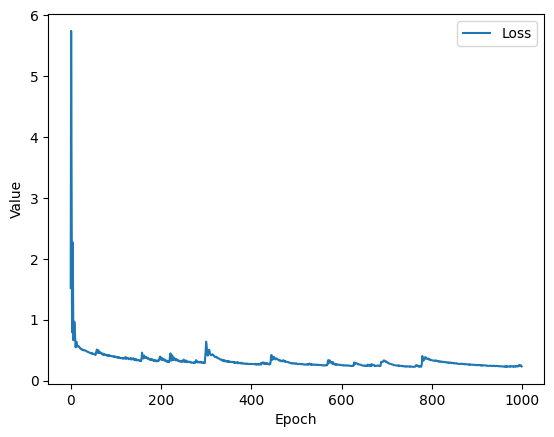

In [314]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


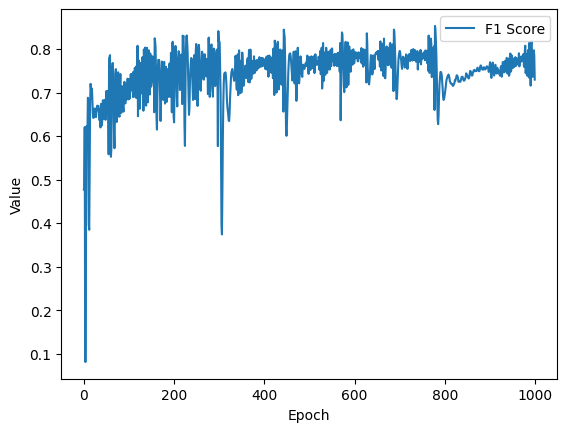

In [315]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

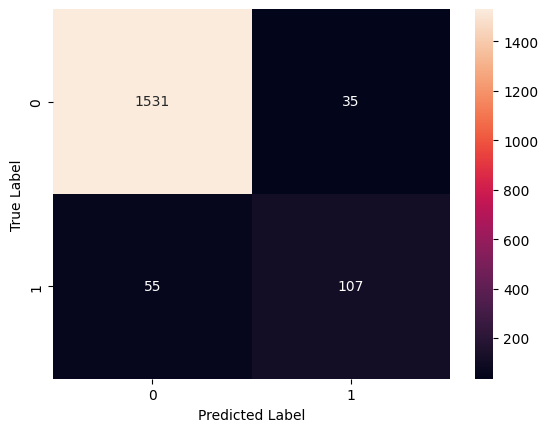

In [316]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Yelp

In [317]:
# Loading data
data_file = loadmat('./Data/YelpChi.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

In [318]:
with open('./Data/yelp_rsr_adjlists.pickle', 'rb') as file:
    upu = pickle.load(file)

with open('./Data/yelp_rtr_adjlists.pickle', 'rb') as file:
    usu = pickle.load(file)

with open('./Data/yelp_rur_adjlists.pickle', 'rb') as file:
    uvu = pickle.load(file)

In [319]:
edges_list_p = []
for i in range(len(upu)):
    edges_list_p.extend([(i, node) for node in upu[i]])

edges_list_p = np.array(edges_list_p)
edges_list_p = edges_list_p.transpose()

In [320]:
edges_list_s = []
for i in range(len(upu)):
    edges_list_s.extend([(i, node) for node in usu[i]])

edges_list_s = np.array(edges_list_s)
edges_list_s = edges_list_s.transpose()

In [321]:
edges_list_v = []
for i in range(len(upu)):
    edges_list_v.extend([(i, node) for node in uvu[i]])

edges_list_v = np.array(edges_list_v)
edges_list_v = edges_list_v.transpose()

In [322]:
train_mask_Yelp = torch.zeros(len(labels), dtype=torch.bool)
val_mask_Yelp = torch.zeros(len(labels), dtype=torch.bool)
test_mask_Yelp = torch.zeros(len(labels), dtype=torch.bool)

nodes = list(range(0, len(labels)))
random.seed(0)
random.shuffle(nodes)
train_nodes = nodes[:int(0.6*len(nodes))]
val_nodes = nodes[int(0.6*len(nodes)):int(0.8*len(nodes))]
test_nodes = nodes[int(0.8*len(nodes)):]

train_mask_Yelp[train_nodes] = True
val_mask_Yelp[val_nodes] = True
test_mask_Yelp[test_nodes] = True


graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index_v=torch.tensor(edges_list_v), 
            edge_index_p=torch.tensor(edges_list_p),
            edge_index_s=torch.tensor(edges_list_s),
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask_Yelp,
            val_mask=val_mask_Yelp,
            test_mask=test_mask_Yelp)

In [323]:
from collections import Counter
count = Counter(labels)

weights = [count[1]/(count[0]+count[1]), count[0]/(count[0]+count[1])]
print(weights)

[0.14529747138442792, 0.854702528615572]


In [324]:
graph

Data(x=[45954, 32], y=[45954], edge_index_v=[2, 144584], edge_index_p=[2, 6851440], edge_index_s=[2, 1193186], train_mask=[45954], val_mask=[45954], test_mask=[45954])

In [325]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_p = GCNConv(32, 20)
        self.conv2_p = GCNConv(20, 15)
        self.conv3_p = GCNConv(15, 10)

        self.conv1_s = GCNConv(32, 20)
        self.conv2_s = GCNConv(20, 15)
        self.conv3_s = GCNConv(15, 10)

        self.conv1_v = GCNConv(32, 20)
        self.conv2_v = GCNConv(20, 15)
        self.conv3_v = GCNConv(15, 10)


        self.dropout = nn.Dropout(0.05)

        self.projection = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )





    def forward(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.conv1_p(x, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv2_p(x_p, edge_index_p)
        x_p = F.relu(x_p)
        x_p = self.conv3_p(x_p, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.conv1_s(x, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv2_s(x_s, edge_index_s)
        x_s = F.relu(x_s)
        x_s = self.conv3_s(x_s, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.conv1_v(x, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv2_v(x_v, edge_index_v)
        x_v = F.relu(x_v)
        x_v = self.conv3_v(x_v, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.dropout(x)
        x = self.projection(x)
        return x

In [326]:
model = GCN()
model = model.to(device)

graph = graph.to(device)

In [327]:
optimizer_gcn = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
model, loss_hist, f1_hist = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 11/1000 [00:01<01:37, 10.14it/s]

Epoch: 010, Train Loss: 0.679, Val Acc: 0.754


  2%|▏         | 21/1000 [00:02<01:33, 10.51it/s]

Epoch: 020, Train Loss: 0.578, Val Acc: 0.652


  3%|▎         | 31/1000 [00:03<01:31, 10.58it/s]

Epoch: 030, Train Loss: 0.537, Val Acc: 0.746


  4%|▍         | 41/1000 [00:04<01:30, 10.55it/s]

Epoch: 040, Train Loss: 0.507, Val Acc: 0.775


  5%|▌         | 51/1000 [00:04<01:29, 10.55it/s]

Epoch: 050, Train Loss: 0.485, Val Acc: 0.766


  6%|▌         | 61/1000 [00:05<01:27, 10.73it/s]

Epoch: 060, Train Loss: 0.469, Val Acc: 0.762


  7%|▋         | 71/1000 [00:06<01:27, 10.58it/s]

Epoch: 070, Train Loss: 0.459, Val Acc: 0.783


  8%|▊         | 81/1000 [00:07<01:26, 10.58it/s]

Epoch: 080, Train Loss: 0.452, Val Acc: 0.731


  9%|▉         | 91/1000 [00:08<01:25, 10.58it/s]

Epoch: 090, Train Loss: 0.445, Val Acc: 0.754


 10%|█         | 101/1000 [00:09<01:23, 10.71it/s]

Epoch: 100, Train Loss: 0.437, Val Acc: 0.767


 11%|█         | 111/1000 [00:10<01:23, 10.59it/s]

Epoch: 110, Train Loss: 0.435, Val Acc: 0.793


 12%|█▏        | 121/1000 [00:11<01:22, 10.65it/s]

Epoch: 120, Train Loss: 0.430, Val Acc: 0.745


 13%|█▎        | 131/1000 [00:12<01:21, 10.60it/s]

Epoch: 130, Train Loss: 0.425, Val Acc: 0.784


 14%|█▍        | 141/1000 [00:13<01:20, 10.64it/s]

Epoch: 140, Train Loss: 0.424, Val Acc: 0.771


 15%|█▌        | 151/1000 [00:14<01:19, 10.68it/s]

Epoch: 150, Train Loss: 0.420, Val Acc: 0.786


 16%|█▌        | 161/1000 [00:15<01:18, 10.72it/s]

Epoch: 160, Train Loss: 0.418, Val Acc: 0.756


 17%|█▋        | 171/1000 [00:16<01:17, 10.65it/s]

Epoch: 170, Train Loss: 0.426, Val Acc: 0.801


 18%|█▊        | 181/1000 [00:17<01:15, 10.79it/s]

Epoch: 180, Train Loss: 0.408, Val Acc: 0.763


 19%|█▉        | 191/1000 [00:18<01:15, 10.66it/s]

Epoch: 190, Train Loss: 0.405, Val Acc: 0.766


 20%|██        | 201/1000 [00:18<01:14, 10.78it/s]

Epoch: 200, Train Loss: 0.402, Val Acc: 0.774


 21%|██        | 211/1000 [00:19<01:12, 10.82it/s]

Epoch: 210, Train Loss: 0.397, Val Acc: 0.776


 22%|██▏       | 221/1000 [00:20<01:12, 10.69it/s]

Epoch: 220, Train Loss: 0.396, Val Acc: 0.776


 23%|██▎       | 231/1000 [00:21<01:11, 10.69it/s]

Epoch: 230, Train Loss: 0.391, Val Acc: 0.777


 24%|██▍       | 241/1000 [00:22<01:11, 10.65it/s]

Epoch: 240, Train Loss: 0.390, Val Acc: 0.782


 25%|██▌       | 251/1000 [00:23<01:09, 10.77it/s]

Epoch: 250, Train Loss: 0.388, Val Acc: 0.775


 26%|██▌       | 261/1000 [00:24<01:09, 10.66it/s]

Epoch: 260, Train Loss: 0.386, Val Acc: 0.796


 27%|██▋       | 271/1000 [00:25<01:08, 10.67it/s]

Epoch: 270, Train Loss: 0.381, Val Acc: 0.801


 28%|██▊       | 281/1000 [00:26<01:06, 10.79it/s]

Epoch: 280, Train Loss: 0.384, Val Acc: 0.794


 29%|██▉       | 291/1000 [00:27<01:04, 10.92it/s]

Epoch: 290, Train Loss: 0.380, Val Acc: 0.765


 30%|███       | 301/1000 [00:28<01:03, 10.95it/s]

Epoch: 300, Train Loss: 0.378, Val Acc: 0.773


 31%|███       | 311/1000 [00:29<01:03, 10.92it/s]

Epoch: 310, Train Loss: 0.374, Val Acc: 0.777


 32%|███▏      | 321/1000 [00:30<01:02, 10.93it/s]

Epoch: 320, Train Loss: 0.375, Val Acc: 0.788


 33%|███▎      | 331/1000 [00:31<01:01, 10.92it/s]

Epoch: 330, Train Loss: 0.372, Val Acc: 0.801


 34%|███▍      | 341/1000 [00:31<01:00, 10.91it/s]

Epoch: 340, Train Loss: 0.373, Val Acc: 0.767


 35%|███▌      | 351/1000 [00:32<00:59, 10.92it/s]

Epoch: 350, Train Loss: 0.367, Val Acc: 0.767


 36%|███▌      | 361/1000 [00:33<00:58, 10.84it/s]

Epoch: 360, Train Loss: 0.369, Val Acc: 0.763


 37%|███▋      | 371/1000 [00:34<00:57, 11.02it/s]

Epoch: 370, Train Loss: 0.364, Val Acc: 0.788


 38%|███▊      | 381/1000 [00:35<00:57, 10.76it/s]

Epoch: 380, Train Loss: 0.368, Val Acc: 0.754


 39%|███▉      | 391/1000 [00:36<00:55, 10.95it/s]

Epoch: 390, Train Loss: 0.363, Val Acc: 0.773


 40%|████      | 401/1000 [00:37<00:54, 10.97it/s]

Epoch: 400, Train Loss: 0.359, Val Acc: 0.780


 41%|████      | 411/1000 [00:38<00:54, 10.88it/s]

Epoch: 410, Train Loss: 0.356, Val Acc: 0.790


 42%|████▏     | 421/1000 [00:39<00:52, 10.97it/s]

Epoch: 420, Train Loss: 0.353, Val Acc: 0.800


 43%|████▎     | 431/1000 [00:40<00:51, 11.01it/s]

Epoch: 430, Train Loss: 0.352, Val Acc: 0.795


 44%|████▍     | 441/1000 [00:41<00:51, 10.94it/s]

Epoch: 440, Train Loss: 0.351, Val Acc: 0.794


 45%|████▌     | 451/1000 [00:41<00:49, 11.04it/s]

Epoch: 450, Train Loss: 0.351, Val Acc: 0.792


 46%|████▌     | 461/1000 [00:42<00:48, 11.16it/s]

Epoch: 460, Train Loss: 0.348, Val Acc: 0.793


 47%|████▋     | 471/1000 [00:43<00:48, 10.86it/s]

Epoch: 470, Train Loss: 0.347, Val Acc: 0.800


 48%|████▊     | 481/1000 [00:44<00:47, 10.89it/s]

Epoch: 480, Train Loss: 0.347, Val Acc: 0.807


 49%|████▉     | 491/1000 [00:45<00:46, 10.95it/s]

Epoch: 490, Train Loss: 0.345, Val Acc: 0.807


 50%|█████     | 501/1000 [00:46<00:45, 10.87it/s]

Epoch: 500, Train Loss: 0.344, Val Acc: 0.809


 51%|█████     | 511/1000 [00:47<00:44, 10.88it/s]

Epoch: 510, Train Loss: 0.342, Val Acc: 0.809


 52%|█████▏    | 521/1000 [00:48<00:43, 10.95it/s]

Epoch: 520, Train Loss: 0.342, Val Acc: 0.809


 53%|█████▎    | 531/1000 [00:49<00:42, 10.93it/s]

Epoch: 530, Train Loss: 0.342, Val Acc: 0.812


 54%|█████▍    | 541/1000 [00:50<00:41, 11.04it/s]

Epoch: 540, Train Loss: 0.342, Val Acc: 0.812


 55%|█████▌    | 551/1000 [00:51<00:41, 10.92it/s]

Epoch: 550, Train Loss: 0.339, Val Acc: 0.808


 56%|█████▌    | 561/1000 [00:52<00:40, 10.94it/s]

Epoch: 560, Train Loss: 0.340, Val Acc: 0.793


 57%|█████▋    | 571/1000 [00:52<00:39, 10.93it/s]

Epoch: 570, Train Loss: 0.337, Val Acc: 0.801


 58%|█████▊    | 581/1000 [00:53<00:38, 11.00it/s]

Epoch: 580, Train Loss: 0.336, Val Acc: 0.816


 59%|█████▉    | 591/1000 [00:54<00:37, 10.95it/s]

Epoch: 590, Train Loss: 0.340, Val Acc: 0.793


 60%|██████    | 601/1000 [00:55<00:36, 10.86it/s]

Epoch: 600, Train Loss: 0.343, Val Acc: 0.793


 61%|██████    | 611/1000 [00:56<00:35, 11.01it/s]

Epoch: 610, Train Loss: 0.334, Val Acc: 0.799


 62%|██████▏   | 621/1000 [00:57<00:34, 10.89it/s]

Epoch: 620, Train Loss: 0.333, Val Acc: 0.800


 63%|██████▎   | 631/1000 [00:58<00:33, 10.95it/s]

Epoch: 630, Train Loss: 0.333, Val Acc: 0.808


 64%|██████▍   | 641/1000 [00:59<00:32, 10.94it/s]

Epoch: 640, Train Loss: 0.333, Val Acc: 0.806


 65%|██████▌   | 651/1000 [01:00<00:31, 11.22it/s]

Epoch: 650, Train Loss: 0.332, Val Acc: 0.808


 66%|██████▌   | 661/1000 [01:01<00:31, 10.90it/s]

Epoch: 660, Train Loss: 0.331, Val Acc: 0.801


 67%|██████▋   | 671/1000 [01:02<00:29, 11.01it/s]

Epoch: 670, Train Loss: 0.331, Val Acc: 0.804


 68%|██████▊   | 681/1000 [01:03<00:29, 10.88it/s]

Epoch: 680, Train Loss: 0.331, Val Acc: 0.800


 69%|██████▉   | 691/1000 [01:03<00:28, 10.89it/s]

Epoch: 690, Train Loss: 0.331, Val Acc: 0.804


 70%|███████   | 701/1000 [01:04<00:27, 10.95it/s]

Epoch: 700, Train Loss: 0.330, Val Acc: 0.799


 71%|███████   | 711/1000 [01:05<00:26, 10.97it/s]

Epoch: 710, Train Loss: 0.328, Val Acc: 0.802


 72%|███████▏  | 721/1000 [01:06<00:25, 11.09it/s]

Epoch: 720, Train Loss: 0.328, Val Acc: 0.800


 73%|███████▎  | 731/1000 [01:07<00:24, 10.82it/s]

Epoch: 730, Train Loss: 0.328, Val Acc: 0.802


 74%|███████▍  | 741/1000 [01:08<00:23, 11.01it/s]

Epoch: 740, Train Loss: 0.326, Val Acc: 0.805


 75%|███████▌  | 751/1000 [01:09<00:22, 10.93it/s]

Epoch: 750, Train Loss: 0.327, Val Acc: 0.808


 76%|███████▌  | 761/1000 [01:10<00:21, 10.92it/s]

Epoch: 760, Train Loss: 0.326, Val Acc: 0.808


 77%|███████▋  | 771/1000 [01:11<00:20, 10.97it/s]

Epoch: 770, Train Loss: 0.325, Val Acc: 0.803


 78%|███████▊  | 781/1000 [01:12<00:20, 10.94it/s]

Epoch: 780, Train Loss: 0.324, Val Acc: 0.799


 79%|███████▉  | 791/1000 [01:13<00:18, 11.01it/s]

Epoch: 790, Train Loss: 0.325, Val Acc: 0.807


 80%|████████  | 801/1000 [01:14<00:18, 10.91it/s]

Epoch: 800, Train Loss: 0.323, Val Acc: 0.808


 81%|████████  | 811/1000 [01:14<00:17, 10.97it/s]

Epoch: 810, Train Loss: 0.322, Val Acc: 0.807


 82%|████████▏ | 821/1000 [01:15<00:16, 10.98it/s]

Epoch: 820, Train Loss: 0.322, Val Acc: 0.808


 83%|████████▎ | 831/1000 [01:16<00:15, 10.92it/s]

Epoch: 830, Train Loss: 0.322, Val Acc: 0.810


 84%|████████▍ | 841/1000 [01:17<00:14, 10.84it/s]

Epoch: 840, Train Loss: 0.322, Val Acc: 0.804


 85%|████████▌ | 851/1000 [01:18<00:13, 11.06it/s]

Epoch: 850, Train Loss: 0.321, Val Acc: 0.807


 86%|████████▌ | 861/1000 [01:19<00:12, 11.04it/s]

Epoch: 860, Train Loss: 0.321, Val Acc: 0.807


 87%|████████▋ | 871/1000 [01:20<00:11, 10.85it/s]

Epoch: 870, Train Loss: 0.321, Val Acc: 0.806


 88%|████████▊ | 881/1000 [01:21<00:10, 10.91it/s]

Epoch: 880, Train Loss: 0.320, Val Acc: 0.808


 89%|████████▉ | 891/1000 [01:22<00:09, 11.01it/s]

Epoch: 890, Train Loss: 0.321, Val Acc: 0.802


 90%|████████▉ | 899/1000 [01:23<00:09, 10.82it/s]

Epoch: 900, Train Loss: 0.320, Val Acc: 0.809
Test Acc: 0.828, Test F1: 0.739


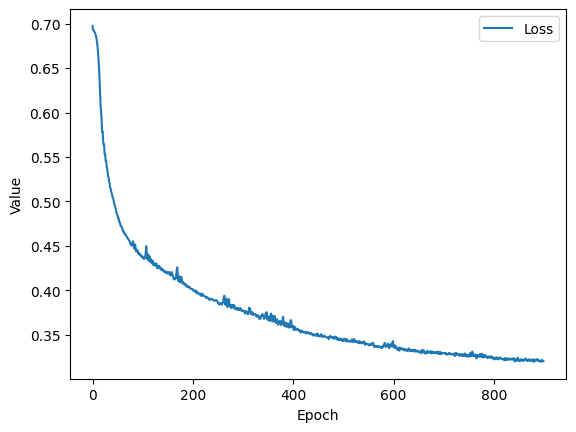

In [328]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


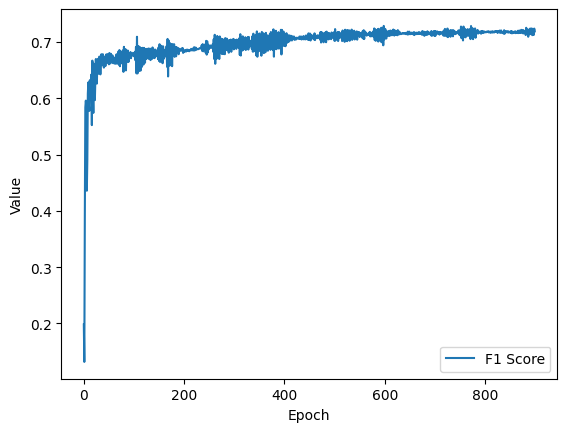

In [329]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

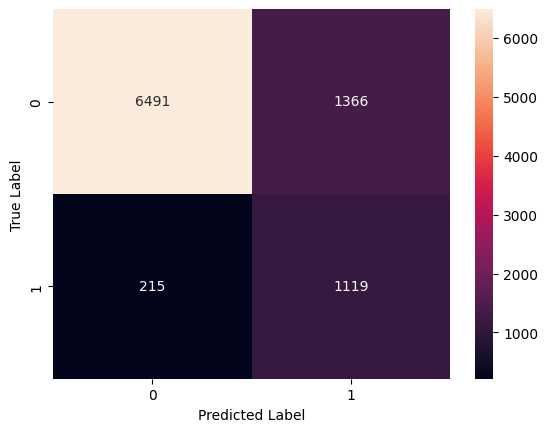

In [330]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Test 3 - Attention

In [350]:
# Loading data
data_file = loadmat('./Data/Amazon.mat')
labels = data_file['label'].flatten()
feat_data = data_file['features'].todense().A

In [351]:
with open('./Data/amz_upu_adjlists.pickle', 'rb') as file:
    upu = pickle.load(file)

with open('./Data/amz_usu_adjlists.pickle', 'rb') as file:
    usu = pickle.load(file)

with open('./Data/amz_uvu_adjlists.pickle', 'rb') as file:
    uvu = pickle.load(file)

In [352]:
edges_list_p = []
for i in range(len(upu)):
    edges_list_p.extend([(i, node) for node in upu[i]])

edges_list_p = np.array(edges_list_p)
edges_list_p = edges_list_p.transpose()

In [353]:
edges_list_s = []
for i in range(len(upu)):
    edges_list_s.extend([(i, node) for node in usu[i]])

edges_list_s = np.array(edges_list_s)
edges_list_s = edges_list_s.transpose()

In [354]:
edges_list_v = []
for i in range(len(upu)):
    edges_list_v.extend([(i, node) for node in uvu[i]])

edges_list_v = np.array(edges_list_v)
edges_list_v = edges_list_v.transpose()

In [355]:
graph = Data(x=torch.tensor(feat_data).float(), 
            edge_index_v=torch.tensor(edges_list_v), 
            edge_index_p=torch.tensor(edges_list_p),
            edge_index_s=torch.tensor(edges_list_s),
            y=torch.tensor(labels).type(torch.int64),
            train_mask=train_mask,
            val_mask=val_mask,
            test_mask=test_mask)

In [356]:
graph

Data(x=[11944, 25], y=[11944], edge_index_v=[2, 2085418], edge_index_p=[2, 363160], edge_index_s=[2, 7144902], train_mask=[11944], val_mask=[11944], test_mask=[11944])

In [366]:
from torch_geometric.nn import GAT
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gat_p = GAT(in_channels=25, 
                        hidden_channels=20, 
                        num_layers=2,
                        out_channels=10,
                        v2=True)
        self.gat_s = GAT(in_channels=25,
                        hidden_channels=20,
                        num_layers=2,
                        out_channels=10,
                        v2=True)
        self.gat_v = GAT(in_channels=25,
                        hidden_channels=20,
                        num_layers=2,
                        out_channels=10,
                        v2=True)


        self.dropout = nn.Dropout(0.05)

        self.projection = nn.Sequential(
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )





    def forward(self, data):
        x, edge_index_p, edge_index_s, edge_index_v = data.x, data.edge_index_p, data.edge_index_s, data.edge_index_v

        x_p = self.gat_p(x, edge_index_p)
        x_p = F.relu(x_p)

        x_s = self.gat_s(x, edge_index_s)
        x_s = F.relu(x_s)

        x_v = self.gat_v(x, edge_index_v)
        x_v = F.relu(x_v)

        x = torch.cat((x_p, x_s, x_v), 1)
        x = self.dropout(x)
        x = self.projection(x)
        return x

In [367]:
model = GCN()
model = model.to(device)

graph = graph.to(device)

In [368]:
optimizer_gcn = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.095, 0.905]).to(device))
model, loss_hist, f1_hist = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 10/1000 [00:18<29:27,  1.79s/it]

Epoch: 010, Train Loss: 1.264, Val Acc: 0.093


  2%|▏         | 20/1000 [00:35<28:09,  1.72s/it]

Epoch: 020, Train Loss: 0.893, Val Acc: 0.887


  3%|▎         | 30/1000 [00:53<28:09,  1.74s/it]

Epoch: 030, Train Loss: 0.655, Val Acc: 0.183


  4%|▍         | 40/1000 [01:11<29:09,  1.82s/it]

Epoch: 040, Train Loss: 0.527, Val Acc: 0.770


  5%|▌         | 50/1000 [01:29<28:28,  1.80s/it]

Epoch: 050, Train Loss: 0.442, Val Acc: 0.859


  6%|▌         | 60/1000 [01:47<27:35,  1.76s/it]

Epoch: 060, Train Loss: 0.365, Val Acc: 0.900


  7%|▋         | 70/1000 [02:04<27:09,  1.75s/it]

Epoch: 070, Train Loss: 0.320, Val Acc: 0.883


  8%|▊         | 80/1000 [02:22<26:47,  1.75s/it]

Epoch: 080, Train Loss: 0.286, Val Acc: 0.892


  9%|▉         | 90/1000 [02:39<26:22,  1.74s/it]

Epoch: 090, Train Loss: 0.273, Val Acc: 0.907


 10%|█         | 100/1000 [02:57<26:20,  1.76s/it]

Epoch: 100, Train Loss: 0.259, Val Acc: 0.914


 11%|█         | 110/1000 [03:14<25:41,  1.73s/it]

Epoch: 110, Train Loss: 0.227, Val Acc: 0.923


 12%|█▏        | 120/1000 [03:32<25:09,  1.71s/it]

Epoch: 120, Train Loss: 0.217, Val Acc: 0.928


 13%|█▎        | 130/1000 [03:49<25:21,  1.75s/it]

Epoch: 130, Train Loss: 0.203, Val Acc: 0.923


 14%|█▍        | 140/1000 [04:07<24:57,  1.74s/it]

Epoch: 140, Train Loss: 0.187, Val Acc: 0.923


 15%|█▌        | 150/1000 [04:24<25:04,  1.77s/it]

Epoch: 150, Train Loss: 0.211, Val Acc: 0.911


 16%|█▌        | 160/1000 [04:42<24:26,  1.75s/it]

Epoch: 160, Train Loss: 0.186, Val Acc: 0.921


 17%|█▋        | 170/1000 [04:59<24:10,  1.75s/it]

Epoch: 170, Train Loss: 0.186, Val Acc: 0.910


 18%|█▊        | 180/1000 [05:17<23:54,  1.75s/it]

Epoch: 180, Train Loss: 0.175, Val Acc: 0.934


 19%|█▉        | 190/1000 [05:34<23:35,  1.75s/it]

Epoch: 190, Train Loss: 0.156, Val Acc: 0.936


 20%|██        | 200/1000 [05:52<23:31,  1.76s/it]

Epoch: 200, Train Loss: 0.142, Val Acc: 0.940


 21%|██        | 210/1000 [06:09<22:41,  1.72s/it]

Epoch: 210, Train Loss: 0.142, Val Acc: 0.935


 22%|██▏       | 220/1000 [06:26<22:20,  1.72s/it]

Epoch: 220, Train Loss: 0.128, Val Acc: 0.935


 23%|██▎       | 230/1000 [06:44<22:27,  1.75s/it]

Epoch: 230, Train Loss: 0.120, Val Acc: 0.938


 24%|██▍       | 240/1000 [07:02<22:32,  1.78s/it]

Epoch: 240, Train Loss: 0.132, Val Acc: 0.928


 25%|██▌       | 250/1000 [07:19<21:30,  1.72s/it]

Epoch: 250, Train Loss: 0.135, Val Acc: 0.936


 26%|██▌       | 260/1000 [07:37<21:49,  1.77s/it]

Epoch: 260, Train Loss: 0.130, Val Acc: 0.929


 27%|██▋       | 270/1000 [07:53<19:16,  1.58s/it]

Epoch: 270, Train Loss: 0.127, Val Acc: 0.925


 28%|██▊       | 280/1000 [08:10<21:03,  1.75s/it]

Epoch: 280, Train Loss: 0.136, Val Acc: 0.924


 29%|██▉       | 290/1000 [08:28<20:54,  1.77s/it]

Epoch: 290, Train Loss: 0.122, Val Acc: 0.930


 30%|███       | 300/1000 [08:46<20:46,  1.78s/it]

Epoch: 300, Train Loss: 0.114, Val Acc: 0.931


 31%|███       | 310/1000 [09:03<20:23,  1.77s/it]

Epoch: 310, Train Loss: 0.105, Val Acc: 0.932


 32%|███▏      | 320/1000 [09:21<20:20,  1.79s/it]

Epoch: 320, Train Loss: 0.110, Val Acc: 0.925


 33%|███▎      | 330/1000 [09:39<19:40,  1.76s/it]

Epoch: 330, Train Loss: 0.109, Val Acc: 0.933


 34%|███▍      | 340/1000 [09:57<18:59,  1.73s/it]

Epoch: 340, Train Loss: 0.111, Val Acc: 0.924


 35%|███▌      | 350/1000 [10:14<18:53,  1.74s/it]

Epoch: 350, Train Loss: 0.102, Val Acc: 0.940


 36%|███▌      | 360/1000 [10:32<19:07,  1.79s/it]

Epoch: 360, Train Loss: 0.091, Val Acc: 0.933


 37%|███▋      | 370/1000 [10:50<18:09,  1.73s/it]

Epoch: 370, Train Loss: 0.094, Val Acc: 0.922


 38%|███▊      | 380/1000 [11:07<18:11,  1.76s/it]

Epoch: 380, Train Loss: 0.092, Val Acc: 0.938


 39%|███▉      | 390/1000 [11:25<18:02,  1.78s/it]

Epoch: 390, Train Loss: 0.088, Val Acc: 0.932


 40%|████      | 400/1000 [11:42<17:29,  1.75s/it]

Epoch: 400, Train Loss: 0.093, Val Acc: 0.930


 41%|████      | 410/1000 [12:00<16:57,  1.72s/it]

Epoch: 410, Train Loss: 0.087, Val Acc: 0.936


 42%|████▏     | 420/1000 [12:17<16:38,  1.72s/it]

Epoch: 420, Train Loss: 0.082, Val Acc: 0.939


 43%|████▎     | 430/1000 [12:34<16:17,  1.71s/it]

Epoch: 430, Train Loss: 0.080, Val Acc: 0.940


 44%|████▍     | 440/1000 [12:52<16:18,  1.75s/it]

Epoch: 440, Train Loss: 0.079, Val Acc: 0.947


 45%|████▌     | 450/1000 [13:09<16:01,  1.75s/it]

Epoch: 450, Train Loss: 0.076, Val Acc: 0.940


 46%|████▌     | 460/1000 [13:27<15:42,  1.75s/it]

Epoch: 460, Train Loss: 0.084, Val Acc: 0.937


 47%|████▋     | 470/1000 [13:44<15:17,  1.73s/it]

Epoch: 470, Train Loss: 0.079, Val Acc: 0.936


 48%|████▊     | 480/1000 [14:02<14:54,  1.72s/it]

Epoch: 480, Train Loss: 0.083, Val Acc: 0.940


 49%|████▉     | 490/1000 [14:19<14:37,  1.72s/it]

Epoch: 490, Train Loss: 0.072, Val Acc: 0.933


 50%|█████     | 500/1000 [14:36<14:21,  1.72s/it]

Epoch: 500, Train Loss: 0.074, Val Acc: 0.938


 51%|█████     | 510/1000 [14:54<14:00,  1.72s/it]

Epoch: 510, Train Loss: 0.069, Val Acc: 0.938


 52%|█████▏    | 520/1000 [15:11<13:45,  1.72s/it]

Epoch: 520, Train Loss: 0.069, Val Acc: 0.947


 53%|█████▎    | 530/1000 [15:28<13:26,  1.72s/it]

Epoch: 530, Train Loss: 0.077, Val Acc: 0.943


 54%|█████▍    | 540/1000 [15:46<13:42,  1.79s/it]

Epoch: 540, Train Loss: 0.071, Val Acc: 0.944


 55%|█████▌    | 550/1000 [16:04<13:08,  1.75s/it]

Epoch: 550, Train Loss: 0.064, Val Acc: 0.942


 56%|█████▌    | 560/1000 [16:21<12:48,  1.75s/it]

Epoch: 560, Train Loss: 0.066, Val Acc: 0.944


 57%|█████▋    | 570/1000 [16:39<12:22,  1.73s/it]

Epoch: 570, Train Loss: 0.067, Val Acc: 0.944


 58%|█████▊    | 580/1000 [16:56<12:01,  1.72s/it]

Epoch: 580, Train Loss: 0.070, Val Acc: 0.939


 59%|█████▉    | 590/1000 [17:13<11:43,  1.72s/it]

Epoch: 590, Train Loss: 0.063, Val Acc: 0.946


 60%|██████    | 600/1000 [17:31<11:27,  1.72s/it]

Epoch: 600, Train Loss: 0.069, Val Acc: 0.939


 61%|██████    | 610/1000 [17:48<11:21,  1.75s/it]

Epoch: 610, Train Loss: 0.076, Val Acc: 0.943


 62%|██████▏   | 620/1000 [18:06<11:03,  1.75s/it]

Epoch: 620, Train Loss: 0.071, Val Acc: 0.944


 63%|██████▎   | 630/1000 [18:23<10:44,  1.74s/it]

Epoch: 630, Train Loss: 0.061, Val Acc: 0.948


 64%|██████▍   | 640/1000 [18:40<10:17,  1.72s/it]

Epoch: 640, Train Loss: 0.062, Val Acc: 0.947


 65%|██████▌   | 650/1000 [18:58<09:59,  1.71s/it]

Epoch: 650, Train Loss: 0.061, Val Acc: 0.944


 66%|██████▌   | 660/1000 [19:15<09:44,  1.72s/it]

Epoch: 660, Train Loss: 0.056, Val Acc: 0.948


 67%|██████▋   | 670/1000 [19:32<09:26,  1.72s/it]

Epoch: 670, Train Loss: 0.059, Val Acc: 0.946


 68%|██████▊   | 680/1000 [19:50<09:09,  1.72s/it]

Epoch: 680, Train Loss: 0.054, Val Acc: 0.948


 69%|██████▉   | 690/1000 [20:07<08:53,  1.72s/it]

Epoch: 690, Train Loss: 0.054, Val Acc: 0.945


 70%|███████   | 700/1000 [20:25<08:43,  1.75s/it]

Epoch: 700, Train Loss: 0.051, Val Acc: 0.948


 71%|███████   | 710/1000 [20:43<09:03,  1.87s/it]

Epoch: 710, Train Loss: 0.057, Val Acc: 0.945


 72%|███████▏  | 720/1000 [21:01<08:25,  1.80s/it]

Epoch: 720, Train Loss: 0.051, Val Acc: 0.951


 73%|███████▎  | 730/1000 [21:19<07:59,  1.78s/it]

Epoch: 730, Train Loss: 0.053, Val Acc: 0.946


 74%|███████▍  | 740/1000 [21:37<07:37,  1.76s/it]

Epoch: 740, Train Loss: 0.048, Val Acc: 0.948


 75%|███████▌  | 750/1000 [21:55<07:10,  1.72s/it]

Epoch: 750, Train Loss: 0.052, Val Acc: 0.950


 76%|███████▌  | 760/1000 [22:12<06:52,  1.72s/it]

Epoch: 760, Train Loss: 0.049, Val Acc: 0.949


 77%|███████▋  | 770/1000 [22:29<06:40,  1.74s/it]

Epoch: 770, Train Loss: 0.047, Val Acc: 0.953


 78%|███████▊  | 780/1000 [22:47<06:23,  1.74s/it]

Epoch: 780, Train Loss: 0.045, Val Acc: 0.946


 79%|███████▉  | 790/1000 [23:04<06:08,  1.76s/it]

Epoch: 790, Train Loss: 0.050, Val Acc: 0.948


 80%|████████  | 800/1000 [23:22<05:43,  1.72s/it]

Epoch: 800, Train Loss: 0.050, Val Acc: 0.950


 81%|████████  | 810/1000 [23:39<05:27,  1.72s/it]

Epoch: 810, Train Loss: 0.051, Val Acc: 0.951


 82%|████████▏ | 820/1000 [23:56<05:09,  1.72s/it]

Epoch: 820, Train Loss: 0.050, Val Acc: 0.948


 83%|████████▎ | 830/1000 [24:14<04:52,  1.72s/it]

Epoch: 830, Train Loss: 0.048, Val Acc: 0.950


 84%|████████▍ | 840/1000 [24:31<04:37,  1.73s/it]

Epoch: 840, Train Loss: 0.048, Val Acc: 0.948


 85%|████████▌ | 850/1000 [24:49<04:17,  1.72s/it]

Epoch: 850, Train Loss: 0.046, Val Acc: 0.951


 86%|████████▌ | 860/1000 [25:06<04:00,  1.72s/it]

Epoch: 860, Train Loss: 0.046, Val Acc: 0.951


 87%|████████▋ | 870/1000 [25:23<03:46,  1.74s/it]

Epoch: 870, Train Loss: 0.043, Val Acc: 0.952


 88%|████████▊ | 880/1000 [25:41<03:30,  1.75s/it]

Epoch: 880, Train Loss: 0.045, Val Acc: 0.953


 89%|████████▉ | 890/1000 [25:58<03:12,  1.75s/it]

Epoch: 890, Train Loss: 0.044, Val Acc: 0.951


 90%|█████████ | 900/1000 [26:16<02:54,  1.75s/it]

Epoch: 900, Train Loss: 0.043, Val Acc: 0.947


 91%|█████████ | 910/1000 [26:33<02:31,  1.69s/it]

Epoch: 910, Train Loss: 0.046, Val Acc: 0.950


 92%|█████████▏| 920/1000 [26:50<02:17,  1.72s/it]

Epoch: 920, Train Loss: 0.042, Val Acc: 0.949


 93%|█████████▎| 930/1000 [27:08<02:00,  1.72s/it]

Epoch: 930, Train Loss: 0.039, Val Acc: 0.952


 94%|█████████▍| 940/1000 [27:25<01:42,  1.71s/it]

Epoch: 940, Train Loss: 0.039, Val Acc: 0.951


 95%|█████████▌| 950/1000 [27:42<01:27,  1.75s/it]

Epoch: 950, Train Loss: 0.039, Val Acc: 0.952


 96%|█████████▌| 960/1000 [28:00<01:09,  1.74s/it]

Epoch: 960, Train Loss: 0.036, Val Acc: 0.956


 97%|█████████▋| 970/1000 [28:17<00:52,  1.75s/it]

Epoch: 970, Train Loss: 0.037, Val Acc: 0.950


 98%|█████████▊| 980/1000 [28:35<00:34,  1.75s/it]

Epoch: 980, Train Loss: 0.036, Val Acc: 0.951


 99%|█████████▉| 990/1000 [28:52<00:17,  1.74s/it]

Epoch: 990, Train Loss: 0.039, Val Acc: 0.954


100%|██████████| 1000/1000 [29:10<00:00,  1.75s/it]

Epoch: 1000, Train Loss: 0.041, Val Acc: 0.953


Test Acc: 0.939, Test F1: 0.833


In [377]:
model, loss_hist2, f1_hist2 = train_node_classifier(model, graph, optimizer_gcn, criterion)

test_acc, f1, predictions = eval_node_classifier(model, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}, Test F1: {f1:.3f}')

  1%|          | 10/1000 [00:18<29:07,  1.77s/it]

Epoch: 010, Train Loss: 0.036, Val Acc: 0.953


  2%|▏         | 20/1000 [00:35<28:45,  1.76s/it]

Epoch: 020, Train Loss: 0.039, Val Acc: 0.950


  3%|▎         | 30/1000 [00:53<28:16,  1.75s/it]

Epoch: 030, Train Loss: 0.036, Val Acc: 0.953


  4%|▍         | 40/1000 [01:10<27:53,  1.74s/it]

Epoch: 040, Train Loss: 0.037, Val Acc: 0.954


  5%|▌         | 50/1000 [01:27<27:20,  1.73s/it]

Epoch: 050, Train Loss: 0.041, Val Acc: 0.953


  6%|▌         | 60/1000 [01:45<27:36,  1.76s/it]

Epoch: 060, Train Loss: 0.033, Val Acc: 0.955


  7%|▋         | 70/1000 [02:04<28:57,  1.87s/it]

Epoch: 070, Train Loss: 0.042, Val Acc: 0.952


  8%|▊         | 80/1000 [02:22<28:25,  1.85s/it]

Epoch: 080, Train Loss: 0.037, Val Acc: 0.949


  9%|▉         | 90/1000 [02:42<29:29,  1.94s/it]

Epoch: 090, Train Loss: 0.042, Val Acc: 0.951


 10%|█         | 100/1000 [03:01<29:40,  1.98s/it]

Epoch: 100, Train Loss: 0.033, Val Acc: 0.948


 11%|█         | 110/1000 [03:21<28:17,  1.91s/it]

Epoch: 110, Train Loss: 0.034, Val Acc: 0.951


 12%|█▏        | 120/1000 [03:40<27:56,  1.91s/it]

Epoch: 120, Train Loss: 0.033, Val Acc: 0.953


 13%|█▎        | 130/1000 [03:59<27:29,  1.90s/it]

Epoch: 130, Train Loss: 0.035, Val Acc: 0.956


 14%|█▍        | 140/1000 [04:18<27:19,  1.91s/it]

Epoch: 140, Train Loss: 0.032, Val Acc: 0.955


 15%|█▌        | 150/1000 [04:37<26:38,  1.88s/it]

Epoch: 150, Train Loss: 0.031, Val Acc: 0.955


 16%|█▌        | 160/1000 [04:56<26:59,  1.93s/it]

Epoch: 160, Train Loss: 0.036, Val Acc: 0.954


 17%|█▋        | 170/1000 [05:15<25:58,  1.88s/it]

Epoch: 170, Train Loss: 0.039, Val Acc: 0.954


 18%|█▊        | 180/1000 [05:34<25:34,  1.87s/it]

Epoch: 180, Train Loss: 0.032, Val Acc: 0.949


 19%|█▉        | 190/1000 [05:53<25:18,  1.88s/it]

Epoch: 190, Train Loss: 0.033, Val Acc: 0.950


 20%|██        | 200/1000 [06:11<24:58,  1.87s/it]

Epoch: 200, Train Loss: 0.032, Val Acc: 0.952


 21%|██        | 210/1000 [06:30<24:36,  1.87s/it]

Epoch: 210, Train Loss: 0.038, Val Acc: 0.954


 22%|██▏       | 220/1000 [06:49<24:18,  1.87s/it]

Epoch: 220, Train Loss: 0.032, Val Acc: 0.953


 23%|██▎       | 230/1000 [07:08<23:58,  1.87s/it]

Epoch: 230, Train Loss: 0.032, Val Acc: 0.954


 24%|██▍       | 240/1000 [07:26<23:43,  1.87s/it]

Epoch: 240, Train Loss: 0.029, Val Acc: 0.952


 25%|██▌       | 250/1000 [07:45<23:25,  1.87s/it]

Epoch: 250, Train Loss: 0.029, Val Acc: 0.954


 26%|██▌       | 260/1000 [08:04<23:04,  1.87s/it]

Epoch: 260, Train Loss: 0.030, Val Acc: 0.952


 27%|██▋       | 270/1000 [08:23<22:48,  1.87s/it]

Epoch: 270, Train Loss: 0.028, Val Acc: 0.953


 28%|██▊       | 280/1000 [08:41<22:22,  1.86s/it]

Epoch: 280, Train Loss: 0.027, Val Acc: 0.954


 29%|██▉       | 290/1000 [09:00<22:13,  1.88s/it]

Epoch: 290, Train Loss: 0.032, Val Acc: 0.953


 30%|███       | 300/1000 [09:19<21:52,  1.88s/it]

Epoch: 300, Train Loss: 0.031, Val Acc: 0.951


 31%|███       | 310/1000 [09:38<21:31,  1.87s/it]

Epoch: 310, Train Loss: 0.032, Val Acc: 0.953


 32%|███▏      | 320/1000 [09:56<21:10,  1.87s/it]

Epoch: 320, Train Loss: 0.031, Val Acc: 0.950


 33%|███▎      | 330/1000 [10:16<21:43,  1.95s/it]

Epoch: 330, Train Loss: 0.032, Val Acc: 0.950


 34%|███▍      | 340/1000 [10:35<21:03,  1.91s/it]

Epoch: 340, Train Loss: 0.029, Val Acc: 0.953


 35%|███▌      | 350/1000 [10:54<20:29,  1.89s/it]

Epoch: 350, Train Loss: 0.031, Val Acc: 0.952


 36%|███▌      | 360/1000 [11:13<19:56,  1.87s/it]

Epoch: 360, Train Loss: 0.024, Val Acc: 0.954


 37%|███▋      | 370/1000 [11:31<19:36,  1.87s/it]

Epoch: 370, Train Loss: 0.030, Val Acc: 0.954


 38%|███▊      | 380/1000 [11:50<19:19,  1.87s/it]

Epoch: 380, Train Loss: 0.029, Val Acc: 0.949


 39%|███▉      | 390/1000 [12:09<18:59,  1.87s/it]

Epoch: 390, Train Loss: 0.029, Val Acc: 0.953


 40%|████      | 400/1000 [12:28<18:44,  1.87s/it]

Epoch: 400, Train Loss: 0.031, Val Acc: 0.954


 41%|████      | 410/1000 [12:46<18:25,  1.87s/it]

Epoch: 410, Train Loss: 0.028, Val Acc: 0.950


 42%|████▏     | 420/1000 [13:05<18:03,  1.87s/it]

Epoch: 420, Train Loss: 0.027, Val Acc: 0.954


 43%|████▎     | 430/1000 [13:24<17:44,  1.87s/it]

Epoch: 430, Train Loss: 0.028, Val Acc: 0.953


 44%|████▎     | 436/1000 [13:37<17:37,  1.87s/it]


Test Acc: 0.947, Test F1: 0.849


In [378]:
loss_hist.extend(loss_hist2)
f1_hist.extend(f1_hist2)

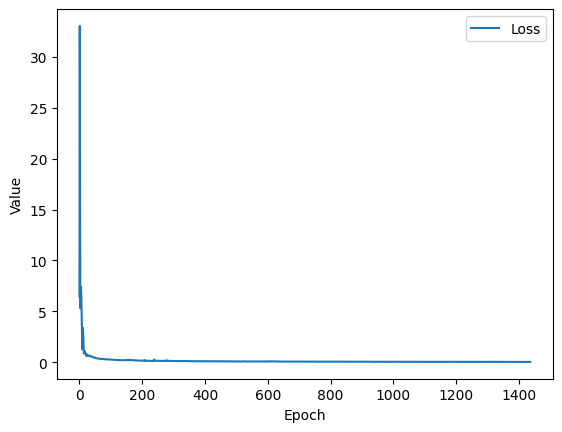

In [379]:
plt.plot(loss_hist, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()


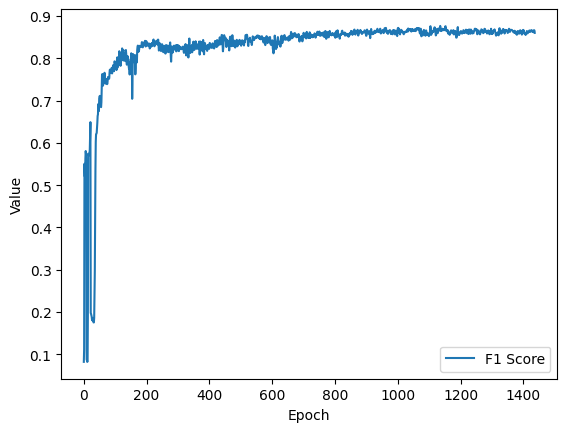

In [380]:
plt.plot(f1_hist, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

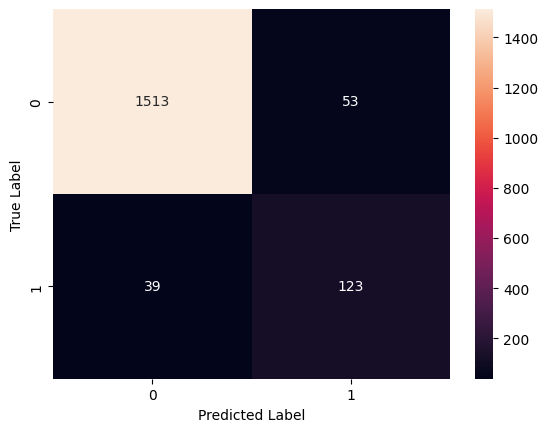

In [381]:
conf_matrix = confusion_matrix(graph.y[graph.test_mask].cpu().numpy(),
                               predictions[graph.test_mask].cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [382]:
from sklearn.metrics import classification_report
report = classification_report(graph.y[graph.test_mask].cpu().numpy(), predictions[graph.test_mask].cpu().numpy())
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1566
           1       0.70      0.76      0.73       162

    accuracy                           0.95      1728
   macro avg       0.84      0.86      0.85      1728
weighted avg       0.95      0.95      0.95      1728



### Dataset and dataloader

In [372]:
# Creating a dataset with the graph

class Amz_dataset(Dataset):
    def __init__(self, graph_list):
        super().__init__(graph_list)
        self.graphs = graph_list

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        data = self.graphs[idx]
        return data
    
dataset = Amz_dataset([graph])

In [373]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [374]:
for batch in dataloader:
    print(batch)
    break

DataBatch(x=[11944, 25], y=[11944], edge_index_v=[2, 2085418], edge_index_p=[2, 363160], edge_index_s=[2, 7144902], train_mask=[11944], val_mask=[11944], test_mask=[11944], batch=[11944], ptr=[2])
